In [6]:
import numpy as np
import pandas as pd

from Utils.utils import *

from IO.read_stereo import *
from Algorithm.graph import *
from Algorithm.distribution import *

In [271]:
# Load the data
gem_df = read_gem_file('F:\Adult.gem')
df = enhance_df_info(gem_df, bin_size=40)
adata = get_anndata(df)

F:\conda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

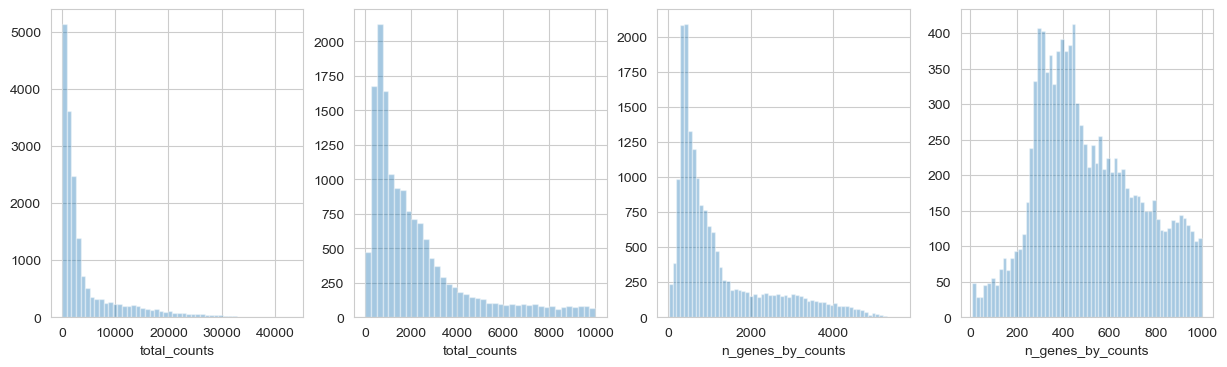

In [204]:
# filter out genes
sc.pp.filter_genes(adata, min_cells=200)
# Clean up data
sc.pp.calculate_qc_metrics(adata, inplace=True)
# Plot the raw data
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 1000], kde=False, bins=60, ax=axs[3])

In [228]:
# Normalize genes count and log1p
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [229]:
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)
gene_list = list(adata.var[adata.var['highly_variable']].index)

<AxesSubplot:ylabel='Count'>

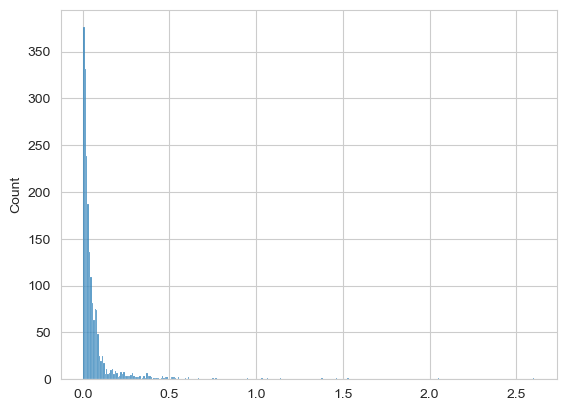

In [231]:
# sc.pp.normalize_total(adata, inplace=True)
var = []
new_list = []
for i in gene_list:
    v = np.var(get_exp_array(adata, i))
    var.append(v)
    if v > .1:
        new_list.append(i)
sns.histplot(var)

In [232]:
len(new_list)

261

In [233]:
gmm_dict = fit_gmms(adata, new_list, n_comp=50, max_iter=500)

Fitting...: 100%|██████████| 261/261 [02:31<00:00,  1.73it/s]


In [340]:
arr = build_gmm_distance_array(gmm_dict, method='optimized_match')

Building distance array...: 100%|██████████| 261/261 [17:03<00:00,  3.92s/it]


In [651]:
result = cluster(arr, n_clusters=15, mds_components=60, method='kmeans')

In [ ]:
b = arr['AMEX60DD003014'].sort_values()
list(b.index[:8])

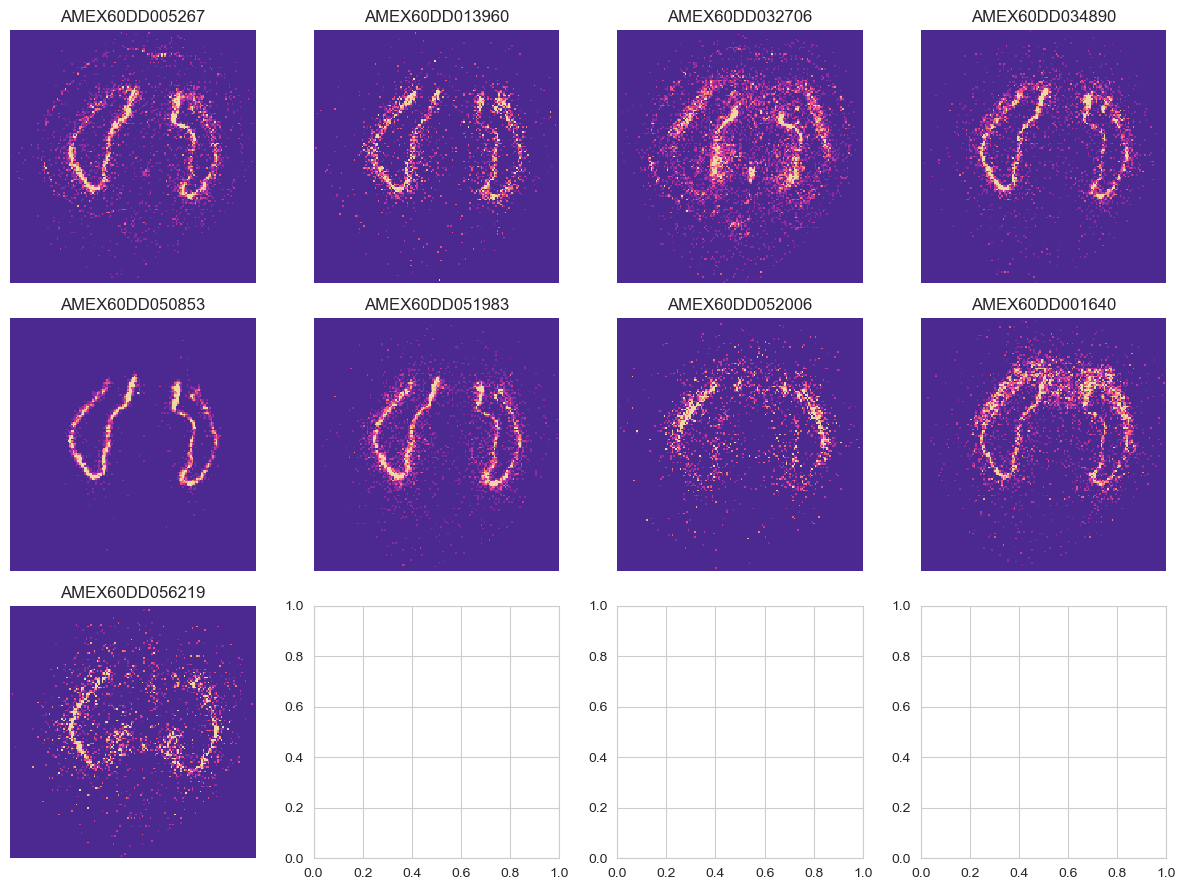

In [697]:
from Utils.plot import *
from palettable.cartocolors.sequential import agSunset_7
def plot_heatmap(result,
                 adata,
                 label,
                 cmap=None,
                 num_cols=5,
                 vmax=99,
                 vmin=0):
    """

    :param cmap:
    :type cmap:
    :param result:
    :type result:
    :param adata:
    :type adata:
    :param label:
    :type label:
    :param num_cols:
    :type num_cols:
    :param vmax:
    :type vmax:
    :param vmin:
    :type vmin:
    """
    gene_list = list(result[result['labels'] == label]['gene_id'])
    if cmap is not None:
        new_cmap = cmap
    else:
        new_colors = ['lightgrey', 'lightblue', '#00FF00', '#FFFF00', '#FFA500', '#FF0000']
        new_cmap = colors.ListedColormap(new_colors)
    num_plots = len(gene_list)
    num_cols = num_cols
    num_rows = (num_plots + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows))
    fig.subplots_adjust(hspace=0.5)
    for i, heatmap in enumerate(gene_list):
        row = i // num_cols
        col = i % num_cols
        if len(axes.shape) == 1:
            ax = axes[i]
        else:
            ax = axes[row, col]
        arr = get_exp_array(adata, heatmap)
        sns.heatmap(arr,
                    cbar=False,
                    ax=ax,
                    cmap=new_cmap,
                    vmax=np.percentile(arr, vmax),
                    vmin=np.percentile(arr, vmin)
                    )
        ax.axis('off')
        ax.set_title(heatmap)
    plt.tight_layout()
    plt.show()
plot_heatmap(result,
             adata,
             label=1,
             num_cols=4,
             vmax=99,
             cmap=agSunset_7.mpl_colors)

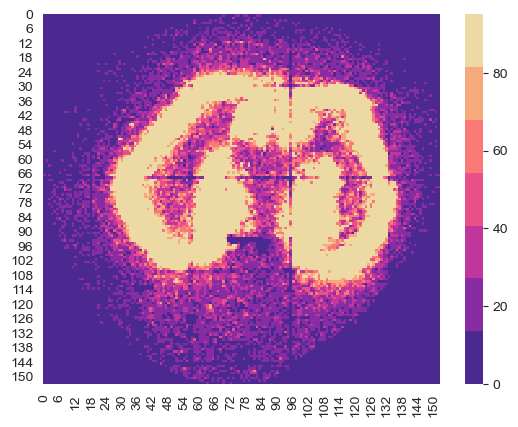

In [694]:
def plot_pattern(result, adata, label, cmap=None, vmax=99):
    li = list(result[result['labels'] == label]['gene_id'])
    total = np.zeros(get_exp_array(adata, li[0]).shape)
    for i in li:
        total += get_exp_array(adata, i)
    if cmap is not None:
        sns.heatmap(total, cmap=cmap, vmax=vmax)
    else:
        sns.heatmap(total, vmax=vmax)

plot_pattern(result,
             adata,
             0,
             vmax=95,
             cmap=agSunset_7.mpl_colors)

In [ ]:
gmm = fit_gmm(adata, 'AMEX60DD020311', n_comp=30)
view_gmm(gmm,scope=(0,150))

In [384]:
import re
ann = pd.read_csv("F:\AmexT_v47-AmexG_v6.0-DD.gtf\AmexT_v47-AmexG_v6.0-DD.gtf", sep="\t", header=None)
ann = ann[ann[2]=='gene']
ann['gene_id']= ann[8].apply(lambda x: re.findall('gene_id "(.*?)";',x)[0])

,0,1,2,3,4,5,6,7,8
0,chr10p,ambMex60DD,gene,313039,315424,1000,+,.,"gene_id ""AMEX60DD000001""; gene_name ""ZFP37 [nr..."
1,chr10p,ambMex60DD,transcript,313039,315424,1000,+,.,"gene_id ""AMEX60DD000001""; transcript_id ""ZFP37..."
2,chr10p,ambMex60DD,exon,313039,314183,1000,+,.,"gene_id ""AMEX60DD000001""; transcript_id ""ZFP37..."
3,chr10p,ambMex60DD,exon,315024,315424,1000,+,.,"gene_id ""AMEX60DD000001""; transcript_id ""ZFP37..."
4,chr10p,ambMex60DD,transcript,313800,315023,1000,+,.,"gene_id ""AMEX60DD000001""; transcript_id ""ZNF79..."
...,...,...,...,...,...,...,...,...,...
1977260,C0217365,ambMex60DD,transcript,6394,6774,1000,-,.,"gene_id ""AMEX60DDU001042275""; transcript_id ""A..."
1977261,C0217365,ambMex60DD,exon,6394,6774,1000,-,.,"gene_id ""AMEX60DDU001042275""; transcript_id ""A..."
1977262,C0217370,ambMex60DD,gene,15670,15901,1000,-,.,"gene_id ""AMEX60DDU001042276""; gene_name ""AMEX6..."
1977263,C0217370,ambMex60DD,transcript,15670,15901,1000,-,.,"gene_id ""AMEX60DDU001042276""; transcript_id ""A..."


F:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


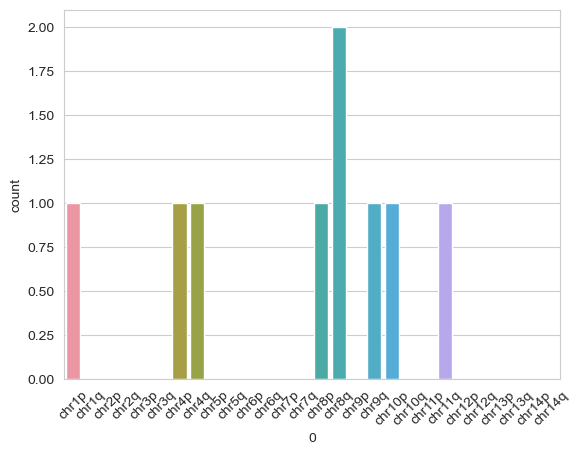

In [698]:
import matplotlib.pyplot as plt

la = []
for i in range(1, 15):
    la.append('chr' + str(i) + 'p')
    la.append('chr' + str(i) + 'q')
la
pattern = list(result[result['labels'] == 1]['gene_id'])
chr = ann[ann[8].isin(pattern)][0]
data = pd.Series(chr)
sns.countplot(data, order = la)
plt.xticks(rotation=45)
plt.show()